In [ ]:
##denpendents
# # Import the os module to work with directories and file paths 
import os
import shutil
import random

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
# Import PIL (Pillow) Image module for basic image validation
from PIL import Image
# Import shutil to move corrupted files to another folder
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy

import warnings
warnings.filterwarnings('ignore')

In [24]:
##folder structures and directory
RAW_DIR = "data/raw"
OUT_DIR = "data"
BAD_DIR = "data/corrupt"

##image resize process
IMG_HEIGHT=180    ##Resize all images
IMG_WIDTH=180   ##Resize all images
CHANNELS=3
BATCH_SIZE=32 
EPOCHS=10

##splitting ratio
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

##Reproducibility
SEED = 42
random.seed(SEED)

In [ ]:
# Define a function to detect and remove corrupted images from a dataset
def clean_corrupt_dataset(image_dir, bad_dir, IMG_HEIGHT, IMG_WIDTH):

    # Create the directory to store corrupted images
    # exist_ok=True prevents errors if the folder already exists
    os.makedirs(bad_dir, exist_ok=True)

    # Walk through the dataset directory recursively
    # root  -> current folder path
    # _     -> list of subdirectories (ignored here)
    # files -> list of files in the current folder
    for root, _, files in os.walk(image_dir):

        # Iterate over every file found in the directory
        for file in files:

            # Process only image files with valid extensions
            # Skip any non-image files (e.g., .txt, .csv, .json)
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Construct the full file path to the image
            src_path = os.path.join(root, file)

            # Assume the image is valid initially
            corrupted = False


            # ---------- PIL CHECK ----------
            # Pillow performs a lightweight validation of the image file
            # This catches header corruption and truncated files
            try:
                # Open the image and verify its internal structure
                # verify() checks file headers and metadata
                with Image.open(src_path) as img:
                    img.verify()

                # Re-open the image to fully load pixel data
                # verify() does not load pixels, so this step is required
                with Image.open(src_path) as img:
                    img.load()

            except Exception:
                # If any Pillow operation fails, mark the image as corrupted
                corrupted = True


            # ---------- TENSORFLOW CHECK (STRICT) ----------
            # TensorFlow uses a stricter decoder than Pillow
            # This ensures compatibility with tf.data pipelines
            if not corrupted:
                try:
                    # Read the image file as raw bytes
                    # TensorFlow decoders operate on byte tensors, not file paths
                    img_bytes = tf.io.read_file(src_path)

                    # Decode the image regardless of format (JPEG or PNG)
                    # channels=3 forces RGB
                    # expand_animations=False prevents GIF-related issues
                    img = tf.image.decode_image(
                        img_bytes,
                        channels=3,
                        expand_animations=False
                    )

                    # Resize the image to a fixed shape
                    # This step forces full decoding and exposes hidden corruption
                    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))

                    # Force full tensor materialization
                    # If the image is corrupted, TensorFlow will crash here
                    _ = tf.cast(img, tf.uint8)

                except Exception:
                    # If TensorFlow fails at any step, mark the image as corrupted
                    corrupted = True


            # ---------- MOVE CORRUPTED FILE ----------
            # If the image failed either Pillow or TensorFlow checks
            if corrupted:
                # Log which file is being removed (useful for debugging)
                print(f"Removing corrupted file: {src_path}")

                # Move the corrupted image to the bad_dir folder
                shutil.move(src_path, os.path.join(bad_dir, file))

In [26]:
##move the corrupted files
clean_corrupt_dataset(RAW_DIR,BAD_DIR, IMG_HEIGHT, IMG_WIDTH)

Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle90_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle691_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle326_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle798_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle690_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle68_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle208_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle910_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle458_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle573_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle457_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle206_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle207_.jpg
Removing corrupted file: data/raw/Maize leaf beetle/leaf beetle572

In [ ]:
ound 25218 files belonging to 22 classes

## Data Loading using Tensorflow

In [27]:
##data loading 
raw_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    RAW_DIR,
    shuffle=True,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 25124 files belonging to 22 classes.


In [28]:
##class name
class_name=raw_dataset.class_names
len(class_name)
class_name

['Cashew anthracnose',
 'Cashew gumosis',
 'Cashew healthy',
 'Cashew leaf miner',
 'Cashew red rust',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic',
 'Maize fall armyworm',
 'Maize grasshoper',
 'Maize healthy',
 'Maize leaf beetle',
 'Maize leaf blight',
 'Maize leaf spot',
 'Maize streak virus',
 'Tomato healthy',
 'Tomato leaf blight',
 'Tomato leaf curl',
 'Tomato septoria leaf spot',
 'Tomato verticulium wilt']

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Data Preprocessing: Way of Splitting data</b></h2>

In [29]:
len(raw_dataset)*TRAIN_RATIO

550.1999999999999

In [30]:
train=raw_dataset.take(550)
len(train)

550

In [31]:
rest_data=raw_dataset.skip(550)
len(rest_data)

236

In [32]:
len(raw_dataset)*VAL_RATIO

117.89999999999999

In [33]:
len(raw_dataset)*TEST_RATIO

117.89999999999999

In [34]:
test=rest_data.take(118)
len(test)

118

In [35]:
val=rest_data.skip(118)
len(val)

118

In [36]:
##user define function to perform data spliting
def train_test_partition(data, train_split=0.80, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=100):
   total_data= len(data)

   if shuffle:
      data = data.shuffle(shuffle_size, SEED)
    
   ## train, test, validation size based on the given data and splitting size
   train_size=int(total_data*train_split)
   val_size=int(total_data*val_split)
   
   ##splitted data
   train_set=data.take(train_size)
   val_set=data.skip(train_size).take(val_size)
   test_set=data.skip(train_size).skip(val_size)

   ## return the train, test and validation set
   return train_set, test_set, val_set

In [37]:
##calling the function to extract train, test, validation data 
train_data, test_data, val_data = train_test_partition(raw_dataset)

In [38]:
##checking 
len(train_data)

628

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Display Images</b></h2>

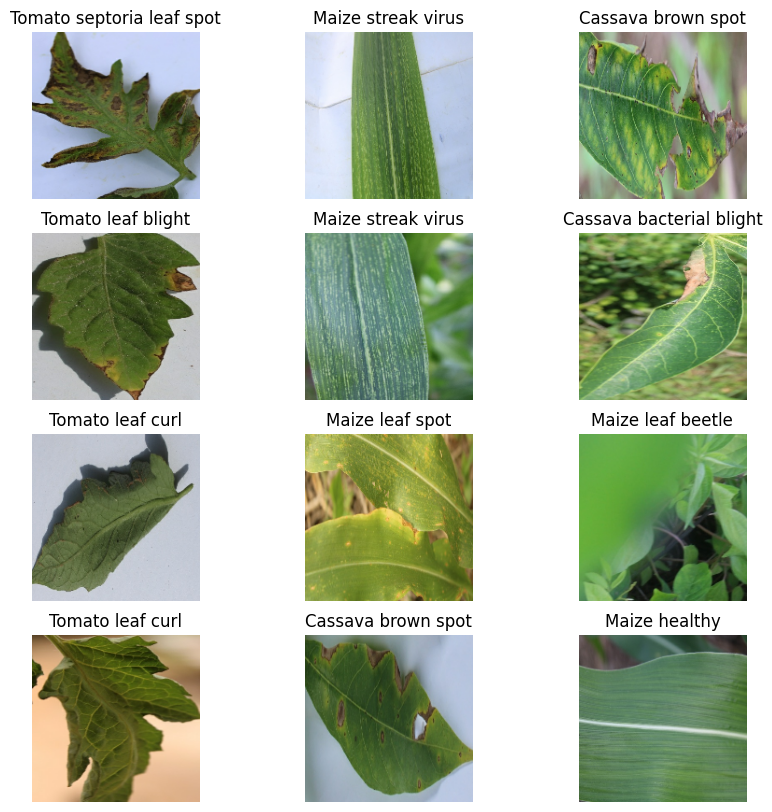

In [39]:
##print images from the train dataset
## taking 1st batch only take(1)

plt.figure(figsize=(10,10))
for image,labels in raw_dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(class_name[labels[i]])
        plt.axis("off")
plt.show()

In [40]:
## number of class
##class name
class_name=raw_dataset.class_names
n_classes=len(class_name)

In [41]:
# train_ds.cardinality().numpy()

In [42]:
## model building
##image input size
input_shapes=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

##my model architecture
model= Sequential([
    ##image resizing
    layers.Resizing(IMG_HEIGHT,IMG_WIDTH),
    ##normalisation layer
    layers.Rescaling(1./255),
    ##randomly flip the images
    layers.RandomFlip("horizontal_and_vertical"),
    ##random rotation
    layers.RandomRotation(0.2),

    ##first convolutional layer
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shapes),
    ##pooling layer
    layers.MaxPooling2D(),
    ##2nd convolutional layer
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    ##3rd convolutional layer
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    ##convert into a vector
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    ##output layer
    layers.Dense(n_classes, activation='softmax')
])

#the model parameters, use the .build() method to see trainable parameters before compiling it with optimizers 
# otherwise it won't be needed
model.build(input_shape=input_shapes)

In [43]:
##helps to check trainable parameter
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (32, 180, 180, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 90, 90, 64)       │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 22)               │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,016,406 (30.58 MB)

 Trainable params: 8,016,406 (30.58 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
##compile the model with optimizers
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [45]:
##training the model
History=model.fit(train_data,
          epochs=EPOCHS,
          verbose=1,
          batch_size=BATCH_SIZE,
          validation_data=val_data)

Epoch 1/10
106/628 ━━━━━━━━━━━━━━━━━━━━ 6:20 730ms/step - accuracy: 0.0921 - loss: 3.0512

KeyboardInterrupt: 